##########################
# Моделирование
##########################

## Импорт библиотек

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd, pyarrow
import numpy as np
import matplotlib.pyplot as plt
import os, sys
from pathlib import Path
import json

import re
from datetime import datetime, timedelta
import os, glob, math
import numpy as np
import pandas as pd
from pathlib import Path
from catboost import CatBoostClassifier, Pool

import tempfile, json, time
from dotenv import load_dotenv
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score


from hyperopt import Trials

# --- Настройка путей и sys.path ---
# Добавляем корневую директорию проекта в sys.path для импорта кастомных модулей
PROJECT_ROOT = Path().cwd().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from src.config import config
from src.logger import logger
from src.database import clickhouse_engine, postgres_engine, ipdr_engine    
from src.predprocessing import *
from src.modeling import *

Configuration loaded successfully.


2025-10-31 23:43:09,753 | my_logger - INFO - ✅ PostgreSQL engine создан | /data/aturov/scoring/src/database.py:21
2025-10-31 23:43:09,795 | my_logger - INFO - ✅ ClickHouse engine создан | /data/aturov/scoring/src/database.py:36
2025-10-31 23:43:09,796 | my_logger - INFO - ✅ IPDR ClickHouse engine создан | /data/aturov/scoring/src/database.py:46


In [2]:
RANDOM_STATE = 5345
RANDOM_STATE_2 = 438
EARLY_S = 200
MAIN_METRIC = 'AUC'


SPLINT_DATE = '2025-01-01'
DATE_FEATURES = '2025-10-30'  # Дата, на которую считаем временные признаки
# Key params (tune as needed)
COUNT_WEEKS = 12               # implies history length N = 12 COUNT_WEEKS = [5, 13]
OVERDUE_DAYS_MAX = 30           # example threshold for 'bad' target OVERDUE_DAYS_MAX = [10, 30]
TOTAL_OVERDUE = 90               # example threshold for total overdue days/amount TOTAL_OVERDUE = [60, 90]

DROP_FEATURES = []
TEST_SIZE = 0.2  # Размер тестовой выборки для train_test_split
TEST_SIZE_2 = 0.1  # Размер тестовой выборки для train_test_split

BETA = 0.9# 2.5  # Параметр для экспоненциальной затухающей функции/ Чем больше - тем сильнее затухание
DELTA = 1  # Шаг для выбора признаков
TARGET_COL = 'target'

# Гиперпараметры
N_TRIALS = 5  # Количество итераций для hyperopt
N_SPLITS = 4  # Количество фолдов для кросс-валидации

PATIENCE = 200  # Параметр ранней остановки

ROUNDS_MIN = 1000 #минимальное количество итераций.
NORM = 0.995 # Шаг 3: Удаление колонок с большим количеством NaN
THRESHOLD_UNIQUE = 5 # Кол-во уникальных значение в колонке при катаром переводитсяв категориальный признак
    
IMPORTANCE_THRESHOLD = 0 #Порог важности признаков
DK = 1 # шаг прибавления параметров
K = 1 # C какого количества признаков отчет
CLASS_CLIENTS = 'all'
NAME_MODEL_CLIENT = f'catboost_{CLASS_CLIENTS}'
NAME_DATA ='features_table'
NAME_DATASET = f'{NAME_DATA}_{COUNT_WEEKS}_{OVERDUE_DAYS_MAX}_{TOTAL_OVERDUE}' # имя файла с табличными признаками


## Execut

In [3]:
df = pd.read_parquet(config.environment.data_processed_path / f'{NAME_DATASET}_{DATE_FEATURES}.parquet')
logger.info(f"Train shape: {df.shape}")
logger.info(f"Train target distribution:\n{df[TARGET_COL].value_counts()}")

train_tab = df[df.index.get_level_values('date_open') < pd.to_datetime(SPLINT_DATE)]
train_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet')
val_tab = df[df.index.get_level_values('date_open') >= pd.to_datetime(SPLINT_DATE)]
val_tab.to_parquet(config.environment.data_final_path / f'{NAME_DATASET}_val_{DATE_FEATURES}.parquet')
logger.info(f"Train shape: {train_tab.shape}, valid shape: {val_tab.shape}")
logger.info(f"Train target distribution:\n{train_tab[TARGET_COL].value_counts()}")
logger.info(f"Valid target distribution:\n{val_tab[TARGET_COL].value_counts()}")
categorical_cols = pd.read_json(config.environment.data_processed_path / f'{NAME_DATASET}_cat_columns_{DATE_FEATURES}.json', typ='series').tolist()
numeric_cols = pd.read_json(config.environment.data_processed_path / f'{NAME_DATASET}_num_columns_{DATE_FEATURES}.json', typ='series').tolist()

2025-10-31 23:43:10,212 | my_logger - INFO - Train shape: (13464, 1725) | /tmp/ipykernel_1067461/3974106151.py:2
2025-10-31 23:43:10,215 | my_logger - INFO - Train target distribution:
target
0    11795
1     1669
Name: count, dtype: int64 | /tmp/ipykernel_1067461/3974106151.py:3
2025-10-31 23:43:11,867 | my_logger - INFO - Train shape: (11606, 1725), valid shape: (1858, 1725) | /tmp/ipykernel_1067461/3974106151.py:9
2025-10-31 23:43:11,870 | my_logger - INFO - Train target distribution:
target
0    11141
1      465
Name: count, dtype: int64 | /tmp/ipykernel_1067461/3974106151.py:10
2025-10-31 23:43:11,871 | my_logger - INFO - Valid target distribution:
target
1    1204
0     654
Name: count, dtype: int64 | /tmp/ipykernel_1067461/3974106151.py:11


In [4]:
path_dataset = f'{config.environment.data_final_path}/{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
X_train, y_train, features, categorical_features = load_and_preprocess_data(path_dataset, DROP_FEATURES, NORM, THRESHOLD_UNIQUE, TARGET_COL)

100%|██████████| 1725/1725 [00:00<00:00, 3505.56it/s]
2025-10-31 23:43:12,807 | my_logger - INFO - Dropped columns due to NaNs: 0 | /data/aturov/scoring/src/predprocessing.py:14
2025-10-31 23:43:13,333 | my_logger - INFO - Dropped columns with single unique value: 73 | /data/aturov/scoring/src/predprocessing.py:23
2025-10-31 23:43:13,334 | my_logger - INFO - Single unique value columns: ['SUBSCRIPTION_FEE_last_nonnull_count', 'BALANCE_END_last_nonnull_count', 'REVENUE_ABONKA_last_nonnull_count', 'USAGE_ABONKA_TP_last_nonnull_count', 'DAYS_WITHOUT_PAYMENT_last_nonnull_count', 'TOTAL_RECHARGE_last_nonnull_count', 'COUNT_RECHARGE_last_nonnull_count', 'USAGE_NUM_OUT_last_nonnull_count', 'USAGE_OUT_ONNET_VOICE_last_nonnull_count', 'USAGE_OUT_OFFNET_VOICE_last_nonnull_count', 'USAGE_OUT_CITY_VOICE_min', 'USAGE_OUT_CITY_VOICE_last_nonnull_count', 'USAGE_OUT_INT_VOICE_min', 'USAGE_OUT_INT_VOICE_last_nonnull_count', 'USAGE_OUT_INT_VOICE_RUSSIA_min', 'USAGE_OUT_INT_VOICE_RUSSIA_last_nonnull_coun

## STEP 2 Model creation

### STAGE 1. ALL Features, gain computer

In [5]:
# Основной блок
history = []  # Инициализация истории
trials = Trials()  # Объект для хранения результатов оптимизации

# Запуск оптимизации гиперпараметров
best_params, history = optimize(trials, MAIN_METRIC, N_TRIALS, RANDOM_STATE, 
                                BETA, X_train, y_train,
                                N_SPLITS, categorical_features, PATIENCE, ROUNDS_MIN)

logger.info(f'Лучшие гиперпараметры: {best_params}')

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2025-10-31 21:30:21,220 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.30000000000000004, 'border_count': 32, 'colsample_bylevel': 0.55, 'depth': 9, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 18, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.05, 'logging_level': 'Silent', 'min_data_in_leaf': 12.0, 'random_strength': 0.180997398, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 21:30:21,221 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 21:30:21,230 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 21:32:21,989 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.07522022765640679}, 'validation': {'Logloss': 0.15780630169053372, 'AUC': 0.6938138970715647}} | /data/aturov/scoring/src/modeling.py:79
2025-10-3

 20%|██        | 1/5 [14:54<59:38, 894.69s/trial, best loss: -0.5380796432094442]

2025-10-31 21:45:15,912 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.30000000000000004, 'border_count': 128, 'colsample_bylevel': 0.55, 'depth': 7, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 15, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.568041584, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 21:45:15,913 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 21:45:15,921 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 21:47:13,952 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.06652141305236642}, 'validation': {'Logloss': 0.15936143749856332, 'AUC': 0.6779494764462708}} | /data/aturov/scoring/src/modeling

 40%|████      | 2/5 [23:19<33:15, 665.22s/trial, best loss: -0.541361621246454] 

2025-10-31 21:53:40,509 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 0.5, 'border_count': 64, 'colsample_bylevel': 0.5, 'depth': 2, 'eval_metric': 'AUC', 'l2_leaf_reg': 4.0, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.8270644060000001, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 21:53:40,510 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 21:53:40,518 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 21:54:00,373 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.2977185694787625}, 'validation': {'Logloss': 0.41521315270496234, 'AUC': 0.7072678664257247}} | /data/aturov/scoring/src/modeling.py:7

 60%|██████    | 3/5 [24:47<13:23, 401.87s/trial, best loss: -0.5565671543938353]

2025-10-31 21:55:08,987 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.15000000000000002, 'border_count': 64, 'colsample_bylevel': 0.9, 'depth': 5, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 15, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.233170493, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 21:55:08,988 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 21:55:08,996 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 21:56:49,538 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.08608487675171304}, 'validation': {'Logloss': 0.15568950408362878, 'AUC': 0.7079207614426815}} | /data/aturov/scoring/src/modeling.p

 80%|████████  | 4/5 [31:50<06:49, 409.97s/trial, best loss: -0.5631028464662555]

2025-10-31 22:02:11,369 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 0.05, 'border_count': 128, 'colsample_bylevel': 0.8, 'depth': 4, 'eval_metric': 'AUC', 'l2_leaf_reg': 4.0, 'leaf_estimation_iterations': 17, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.1, 'logging_level': 'Silent', 'min_data_in_leaf': 12.0, 'random_strength': 0.640203743, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 22:02:11,370 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 22:02:11,378 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 22:03:03,029 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.1609786462875267}, 'validation': {'Logloss': 0.4255556590255184, 'AUC': 0.6834325568730351}} | /data/aturov/scoring/src/modeling.py:79
2025-10-31 22:03:04

100%|██████████| 5/5 [35:07<00:00, 421.48s/trial, best loss: -0.5631028464662555]

2025-10-31 22:05:28,628 | my_logger - INFO - Лучшие гиперпараметры: {'auto_class_weights': np.int64(0), 'bagging_temperature': np.float64(0.15000000000000002), 'border_count': np.int64(1), 'colsample_bylevel': np.float64(0.9), 'depth': np.int64(4), 'l2_leaf_reg': np.float64(1.0), 'leaf_estimation_iterations': np.int64(14), 'leaf_estimation_method': np.int64(1), 'learning_rate': np.float64(0.07500000000000001), 'min_data_in_leaf': np.float64(11.0), 'random_strength': np.float64(0.233170493)} | /tmp/ipykernel_866321/1715680589.py:10


In [6]:
# Отображение всей истории и выбор лучшего результата
best_log = display_history_and_select_best(history)

Full hyperparameter optimization history:
Trial 1:
{'best_iter': 1000,
 'i_metrics': [(0.9351206061946675,
                0.6938138970715647,
                np.float64(-0.5583732951850106)),
               (0.9823896243596727,
                0.7099157574920592,
                np.float64(-0.5555284547250418)),
               (0.9930883698346229,
                0.6771853525660868,
                np.float64(-0.5096031599472483)),
               (0.9989978547748405,
                0.6960997957035845,
                np.float64(-0.5300041207538903))],
 'metrics': [0.9773991137909508, 0.6942537007083238],
 'models': [<catboost.core.CatBoostClassifier object at 0x7fbad8209120>,
 'objective': np.float64(-0.5380796432094442),
 'params': {'auto_class_weights': None,
            'bagging_temperature': 0.30000000000000004,
            'border_count': 32,
            'colsample_bylevel': 0.55,
            'depth': 9,
            'eval_metric': 'AUC',
            'l2_leaf_reg': 1.0,
         

In [7]:
best_model, best_fold_index = select_best_model(best_log)

logger.info(f"Выбрана лучшая модель для сохранения.{best_model.best_score_}")


2025-10-31 22:05:28,686 | my_logger - INFO - Выбрана лучшая модель для сохранения. Лучший objective: 0.5716062720403094, Fold: 2 | /data/aturov/scoring/src/modeling.py:329
2025-10-31 22:05:28,687 | my_logger - INFO - Выбрана лучшая модель для сохранения.{'learn': {'Logloss': 0.10517024506963964}, 'validation': {'Logloss': 0.16114462354467926, 'AUC': 0.6722358075899213}} | /tmp/ipykernel_866321/2843920113.py:3


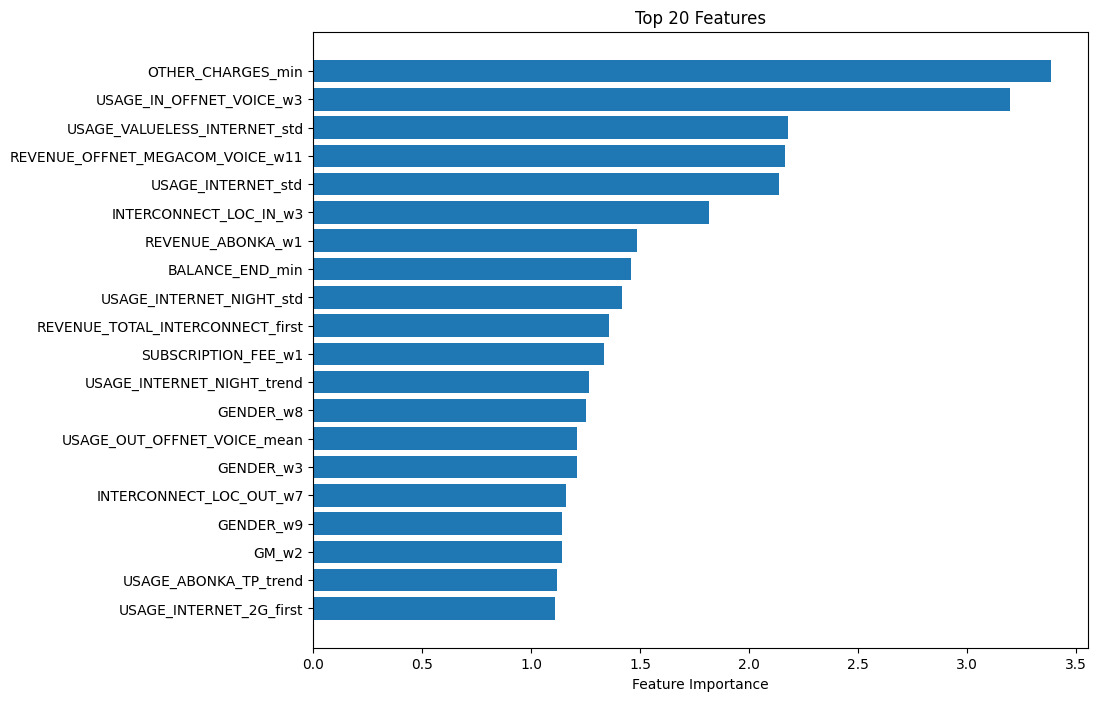

In [8]:
feature_importance = plot_feature_importance(best_model, best_model.feature_names_, n_features=20)

In [9]:
df_gain, model_file_path = save_best_model(f'{NAME_MODEL_CLIENT}_start', 
                                           config.environment.model_path_raw, best_model, 
                                           IMPORTANCE_THRESHOLD, config.environment.data_raw_path,
                                            CLASS_CLIENTS)

2025-10-31 22:05:29,074 | my_logger - INFO - Важность признаков рассчитана и нормализована. | /data/aturov/scoring/src/modeling.py:368
2025-10-31 22:05:29,076 | my_logger - INFO - Признаки с важностью выше 0 отфильтрованы. | /data/aturov/scoring/src/modeling.py:372
2025-10-31 22:05:29,080 | my_logger - INFO - Модель сохранена по пути: /data/aturov/scoring/models/raw/catboost_all_start.cbm | /data/aturov/scoring/src/modeling.py:377
2025-10-31 22:05:29,084 | my_logger - INFO - Важность признаков сохранена: /data/aturov/scoring/data/raw/df_gain_all.csv | /data/aturov/scoring/src/modeling.py:382


### STAGE 2. Feature selection

In [10]:
model_file_path = f'{config.environment.model_path_raw}/{NAME_MODEL_CLIENT}_start.cbm'
model, best_params, rounds_1stage, feature_names, categorical_features, df_gain = load_model_and_get_info(model_file_path)

2025-10-31 22:05:29,117 | my_logger - INFO - Параметры модели: {'verbose': 0, 'leaf_estimation_method': 'Gradient', 'random_seed': 5345, 'border_count': 64, 'min_data_in_leaf': 11, 'random_strength': 0.233170493, 'learning_rate': 0.075, 'task_type': 'CPU', 'logging_level': 'Silent', 'iterations': 1000, 'l2_leaf_reg': 1, 'od_wait': 200, 'thread_count': 60, 'depth': 5, 'bagging_temperature': 0.15, 'rsm': 0.9, 'eval_metric': 'AUC', 'leaf_estimation_iterations': 15, 'loss_function': 'Logloss'} | /data/aturov/scoring/src/modeling.py:423
2025-10-31 22:05:29,118 | my_logger - INFO - Лучшее число итераций: 83 | /data/aturov/scoring/src/modeling.py:424
2025-10-31 22:05:29,119 | my_logger - INFO - Признаки: ['SUBSCRIPTION_FEE_w1', 'SUBSCRIPTION_FEE_w2', 'SUBSCRIPTION_FEE_w3', 'SUBSCRIPTION_FEE_w4', 'SUBSCRIPTION_FEE_w5', 'SUBSCRIPTION_FEE_w6', 'SUBSCRIPTION_FEE_w7', 'SUBSCRIPTION_FEE_w8', 'SUBSCRIPTION_FEE_w9', 'SUBSCRIPTION_FEE_w10', 'SUBSCRIPTION_FEE_w11', 'SUBSCRIPTION_FEE_w12', 'BALANCE_END_

In [11]:
# Обработка данных и разделение на обучающую и тестовую выборки
path_dataset = config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
df = pd.read_parquet(path_dataset)
X_train, X_valid, y_train, y_valid, X, y = process_and_split_data(df, feature_names, categorical_features, TARGET_COL, TEST_SIZE, RANDOM_STATE_2)

2025-10-31 22:05:31,579 | my_logger - INFO - Размер исходного датасета: (11606, 1651), (11606,) | /data/aturov/scoring/src/predprocessing.py:134
2025-10-31 22:05:31,581 | my_logger - INFO - Размер обучающей выборки: (9284, 1651), (9284,) | /data/aturov/scoring/src/predprocessing.py:135
2025-10-31 22:05:31,581 | my_logger - INFO - Размер валидационной выборки: (2322, 1651), (2322,) | /data/aturov/scoring/src/predprocessing.py:136


In [12]:
# Оценка модели с использованием только необходимых признаков
results = feature_selection_and_evaluation(df_gain, X_train, X_valid, y_train, 
                                                        y_valid, best_params, rounds_1stage, 
                                                        categorical_features, BETA, DK, K,
                                                        n_jobs=-1)
    

  0%|          | 0/1651 [00:00<?, ?it/s]

  4%|▍         | 64/1651 [00:00<00:06, 264.05it/s]

Configuration loaded successfully.


  8%|▊         | 128/1651 [00:03<00:46, 32.70it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


  8%|▊         | 128/1651 [00:15<00:46, 32.70it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded

 78%|███████▊  | 1280/1651 [17:02<05:33,  1.11it/s]/data/aturov/scoring/.venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


 89%|████████▉ | 1472/1651 [20:00<02:44,  1.09it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


 93%|█████████▎| 1536/1651 [21:00<01:45,  1.09it/s]

Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


100%|██████████| 1651/1651 [22:00<00:00,  1.25it/s]


Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.
Configuration loaded successfully.


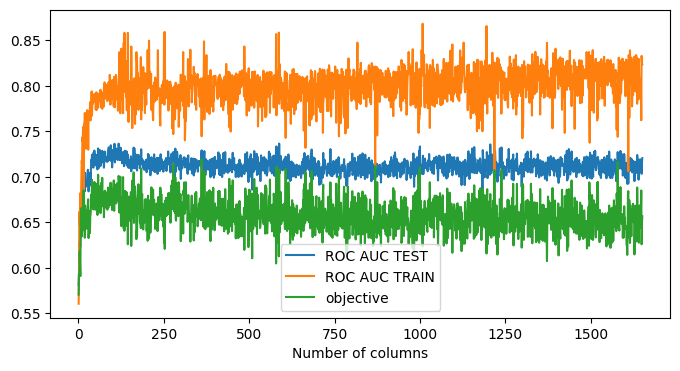

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

results.plot(x='Number of columns', y=['ROC AUC TEST', 'ROC AUC TRAIN', 'objective'], figsize=(8, 4), grid=True)
plt.grid()

In [14]:
results.sort_values(by='objective', ascending=False).head(10)

,Number of columns,ROC AUC TEST,ROC AUC TRAIN,objective,Columns
360,361,0.729162,0.744603,0.719099,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
1578,1579,0.727202,0.744051,0.716257,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
277,278,0.727256,0.747045,0.714418,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
868,869,0.716764,0.709009,0.711779,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
579,580,0.733482,0.767692,0.711243,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
999,1000,0.733423,0.769143,0.710220,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
183,184,0.730275,0.763109,0.709011,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
606,607,0.722139,0.742858,0.708798,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
587,588,0.736565,0.780280,0.708148,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."
1238,1239,0.732262,0.770056,0.707772,"[OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ..."


In [ ]:
# Убедимся, что все значения в столбце objective являются числовыми
results['objective'] = pd.to_numeric(results['objective'], errors='coerce')

# Сортировка и выбор наибольшего значения objective

best_index = results['objective'].idxmax()
#best_index = 1578
best_row = results.loc[best_index]

logger.info(f"Индекс с самым большим objective: {best_index}")
logger.info(f"Лучшие результаты:\n{best_row}")

2025-10-31 22:35:10,247 | my_logger - INFO - Индекс с самым большим objective: 1578 | /tmp/ipykernel_866321/4261226402.py:10


2025-10-31 22:35:10,249 | my_logger - INFO - Лучшие результаты:
Number of columns                                                 1579
ROC AUC TEST                                                  0.727202
ROC AUC TRAIN                                                 0.744051
objective                                                     0.716257
Columns              [OTHER_CHARGES_min, USAGE_IN_OFFNET_VOICE_w3, ...
Name: 1578, dtype: object | /tmp/ipykernel_866321/4261226402.py:11


In [17]:
f'{config.environment.data_processed_path}/df_gain_{CLASS_CLIENTS}.csv'

'/data/aturov/scoring/data/processed/df_gain_all.csv'

In [18]:
# Выбираем индекс с нужным количеством признаков из results
iindex = best_index  # Индекс строки с 106 признаками
# Получаем количество признаков
columns_count = results.loc[iindex, 'Number of columns']

# Выбираем признаки из df_gain на основе количества признаков
columns_name = df_gain.iloc[:columns_count]['name'].values
path_gain = f'{config.environment.data_processed_path}/df_gain_{CLASS_CLIENTS}.csv'
# Сохраняем выбранные признаки в CSV файл
df_gain.iloc[:columns_count].to_csv(path_gain)

# Проверяем выбранные признаки
df_gain.iloc[:columns_count].head(10)

,name,value
1408,OTHER_CHARGES_min,0.0339
170,USAGE_IN_OFFNET_VOICE_w3,0.0320
1209,USAGE_VALUELESS_INTERNET_std,0.0218
622,REVENUE_OFFNET_MEGACOM_VOICE_w11,0.0217
1216,USAGE_INTERNET_std,0.0214
470,INTERCONNECT_LOC_IN_w3,0.0182
24,REVENUE_ABONKA_w1,0.0149
1115,BALANCE_END_min,0.0146
1340,USAGE_INTERNET_NIGHT_std,0.0142
1383,REVENUE_TOTAL_INTERCONNECT_first,0.0136


In [19]:
df_gain.iloc[:columns_count].shape[0]

1579

### STAGE 3 Final optimization of params

#### STEP 3.1 FINAL MODEL optimize

In [5]:
path_gain = f'{config.environment.data_processed_path}/df_gain_{CLASS_CLIENTS}.csv'
path_train = config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
DROP_FEATURES = []
DROP_FEATURES = drop_features_func(path_gain, 
                                   DROP_FEATURES, 
                                   path_train
                                   )
model_file_path = f'{config.environment.model_path_raw}/{NAME_MODEL_CLIENT}_start.cbm'
df_gain = pd.read_csv(path_gain)
model, best_params, rounds_1stage, feature_names, categorical_features, __ = load_model_and_get_info(model_file_path)
categorical_features = [col for col in categorical_features if col in df_gain['name'].values]

2025-10-31 22:46:17,981 | my_logger - INFO - Параметры модели: {'verbose': 0, 'leaf_estimation_method': 'Gradient', 'random_seed': 5345, 'border_count': 64, 'min_data_in_leaf': 11, 'random_strength': 0.233170493, 'learning_rate': 0.075, 'task_type': 'CPU', 'logging_level': 'Silent', 'iterations': 1000, 'l2_leaf_reg': 1, 'od_wait': 200, 'thread_count': 60, 'depth': 5, 'bagging_temperature': 0.15, 'rsm': 0.9, 'eval_metric': 'AUC', 'leaf_estimation_iterations': 15, 'loss_function': 'Logloss'} | /data/aturov/scoring/src/modeling.py:423
2025-10-31 22:46:17,983 | my_logger - INFO - Лучшее число итераций: 83 | /data/aturov/scoring/src/modeling.py:424
2025-10-31 22:46:17,984 | my_logger - INFO - Признаки: ['SUBSCRIPTION_FEE_w1', 'SUBSCRIPTION_FEE_w2', 'SUBSCRIPTION_FEE_w3', 'SUBSCRIPTION_FEE_w4', 'SUBSCRIPTION_FEE_w5', 'SUBSCRIPTION_FEE_w6', 'SUBSCRIPTION_FEE_w7', 'SUBSCRIPTION_FEE_w8', 'SUBSCRIPTION_FEE_w9', 'SUBSCRIPTION_FEE_w10', 'SUBSCRIPTION_FEE_w11', 'SUBSCRIPTION_FEE_w12', 'BALANCE_END_

In [6]:
# Обработка данных и разделение на обучающую и тестовую выборки
X_train, y_train, features, categorical_features = load_and_preprocess_data(path_train, DROP_FEATURES, 
                                                                            NORM, THRESHOLD_UNIQUE, TARGET_COL, 
                                                                            del_col_flag=False,
                                                                            categorical_features=categorical_features
                                                                            )
logger.info(f'Размер датафрейма{X_train.shape}')

2025-10-31 22:46:21,328 | my_logger - INFO - Размер датафрейма(11606, 1579) | /tmp/ipykernel_1031365/3276125089.py:7


In [7]:
# Основной блок
history2 = []  # Инициализация истории
trials = Trials()  # Объект для хранения результатов оптимизации

# Запуск оптимизации гиперпараметров
best_params2, history2 = optimize(trials, MAIN_METRIC, N_TRIALS, RANDOM_STATE, 
                                  BETA, X_train, y_train, N_SPLITS, categorical_features, 
                                  PATIENCE, ROUNDS_MIN
                                  )

logger.info(f'Лучшие гиперпараметры: {best_params2}')

  0%|          | 0/5 [00:00<?, ?trial/s, best loss=?]

2025-10-31 22:46:28,347 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.30000000000000004, 'border_count': 32, 'colsample_bylevel': 0.55, 'depth': 9, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 18, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.05, 'logging_level': 'Silent', 'min_data_in_leaf': 12.0, 'random_strength': 0.180997398, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 22:46:28,348 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 22:46:28,350 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 22:50:42,325 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.04333292850296452}, 'validation': {'Logloss': 0.15864018920469092, 'AUC': 0.6703839394014407}} | /data/aturov/scoring/src/modeling.py:79
2025-10-3

 20%|██        | 1/5 [13:53<55:32, 833.13s/trial, best loss: -0.5293407526950434]

2025-10-31 23:00:21,476 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.30000000000000004, 'border_count': 128, 'colsample_bylevel': 0.55, 'depth': 7, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 15, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.568041584, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 23:00:21,477 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 23:00:21,479 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 23:02:15,912 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.06894975268075283}, 'validation': {'Logloss': 0.15589878543909322, 'AUC': 0.7021499121221872}} | /data/aturov/scoring/src/modeling

 40%|████      | 2/5 [22:30<32:21, 647.27s/trial, best loss: -0.5372386801966182]

2025-10-31 23:08:58,641 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 0.5, 'border_count': 64, 'colsample_bylevel': 0.5, 'depth': 2, 'eval_metric': 'AUC', 'l2_leaf_reg': 4.0, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.8270644060000001, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 23:08:58,642 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 23:08:58,644 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 23:09:16,792 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.3081465185841102}, 'validation': {'Logloss': 0.4178423470805154, 'AUC': 0.6966946802980419}} | /data/aturov/scoring/src/modeling.py:79

 60%|██████    | 3/5 [23:52<12:58, 389.37s/trial, best loss: -0.5634181318937602]

2025-10-31 23:10:21,116 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': None, 'bagging_temperature': 0.15000000000000002, 'border_count': 64, 'colsample_bylevel': 0.9, 'depth': 5, 'eval_metric': 'AUC', 'l2_leaf_reg': 1.0, 'leaf_estimation_iterations': 15, 'leaf_estimation_method': 'Gradient', 'learning_rate': 0.07500000000000001, 'logging_level': 'Silent', 'min_data_in_leaf': 11.0, 'random_strength': 0.233170493, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 23:10:21,117 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 23:10:21,119 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 23:13:09,223 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.0630150205206041}, 'validation': {'Logloss': 0.156793578013813, 'AUC': 0.6979076416565586}} | /data/aturov/scoring/src/modeling.py:7

 80%|████████  | 4/5 [31:06<06:46, 406.71s/trial, best loss: -0.5634181318937602]

2025-10-31 23:17:34,394 | my_logger - INFO - Начало оценки модели с параметрами: {'auto_class_weights': 'SqrtBalanced', 'bagging_temperature': 0.05, 'border_count': 128, 'colsample_bylevel': 0.8, 'depth': 4, 'eval_metric': 'AUC', 'l2_leaf_reg': 4.0, 'leaf_estimation_iterations': 17, 'leaf_estimation_method': 'Newton', 'learning_rate': 0.1, 'logging_level': 'Silent', 'min_data_in_leaf': 12.0, 'random_strength': 0.640203743, 'task_type': 'CPU', 'thread_count': 60} | /data/aturov/scoring/src/modeling.py:57
2025-10-31 23:17:34,394 | my_logger - INFO - Кол-во фолдов для перекрестной валидации: 4 | /data/aturov/scoring/src/modeling.py:58
2025-10-31 23:17:34,397 | my_logger - INFO - Начало обучения на фолде 1/4 | /data/aturov/scoring/src/modeling.py:62
2025-10-31 23:18:23,881 | my_logger - INFO - Метрики для фолда 1: {'learn': {'Logloss': 0.1573123696093919}, 'validation': {'Logloss': 0.42804561004426267, 'AUC': 0.6743415352625195}} | /data/aturov/scoring/src/modeling.py:79
2025-10-31 23:18:2

100%|██████████| 5/5 [34:19<00:00, 411.89s/trial, best loss: -0.5697849728846286]

2025-10-31 23:20:47,816 | my_logger - INFO - Лучшие гиперпараметры: {'auto_class_weights': np.int64(2), 'bagging_temperature': np.float64(0.05), 'border_count': np.int64(2), 'colsample_bylevel': np.float64(0.8), 'depth': np.int64(3), 'l2_leaf_reg': np.float64(4.0), 'leaf_estimation_iterations': np.int64(16), 'leaf_estimation_method': np.int64(0), 'learning_rate': np.float64(0.1), 'min_data_in_leaf': np.float64(12.0), 'random_strength': np.float64(0.640203743)} | /tmp/ipykernel_1031365/2115599908.py:11


In [8]:
# Отображение всей истории и выбор лучшего результата
best_log2 = display_history_and_select_best(history2)


Full hyperparameter optimization history:
Trial 1:
{'best_iter': 1000,
 'i_metrics': [(0.9948712144984645,
                0.670374656533901,
                np.float64(-0.5005912214492299)),
               (0.9944248196629305,
                0.7111034387515536,
                np.float64(-0.5510517141758998)),
               (0.9910079540669436,
                0.6723549804989786,
                np.float64(-0.5047174509520997)),
               (0.9390308218379533,
                0.6990063765244846,
                np.float64(-0.5632017227857437))],
 'metrics': [0.9798337025165729, 0.6882098630772294],
 'models': [<catboost.core.CatBoostClassifier object at 0x7fa04450ab60>,
 'objective': np.float64(-0.5293407526950434),
 'params': {'auto_class_weights': None,
            'bagging_temperature': 0.30000000000000004,
            'border_count': 32,
            'colsample_bylevel': 0.55,
            'depth': 9,
            'eval_metric': 'AUC',
            'l2_leaf_reg': 1.0,
          

In [9]:
best_model2, best_fold_index2 = select_best_model(best_log2)

2025-10-31 23:20:47,883 | my_logger - INFO - Выбрана лучшая модель для сохранения. Лучший objective: 0.6036264827556255, Fold: 2 | /data/aturov/scoring/src/modeling.py:329


In [10]:
best_model2.best_score_

{'learn': {'Logloss': 0.19830198074761443},
 'validation': {'Logloss': 0.42742535195298487, 'AUC': 0.6840880950906952}}

In [11]:
df_gain2, model_file_path = save_best_model(f'{NAME_MODEL_CLIENT}_processed', 
                                            config.environment.model_path_processed, 
                                            best_model2, IMPORTANCE_THRESHOLD, 
                                            config.environment.data_processed_path, 
                                            CLASS_CLIENTS)

2025-10-31 23:20:47,940 | my_logger - INFO - Важность признаков рассчитана и нормализована. | /data/aturov/scoring/src/modeling.py:368
2025-10-31 23:20:47,941 | my_logger - INFO - Признаки с важностью выше 0 отфильтрованы. | /data/aturov/scoring/src/modeling.py:372
2025-10-31 23:20:47,944 | my_logger - INFO - Модель сохранена по пути: /data/aturov/scoring/models/processed/catboost_all_processed.cbm | /data/aturov/scoring/src/modeling.py:377
2025-10-31 23:20:47,948 | my_logger - INFO - Важность признаков сохранена: /data/aturov/scoring/data/processed/df_gain_all.csv | /data/aturov/scoring/src/modeling.py:382


#### STEP 3.2 FINAL MODEL training

In [6]:
path_gain = f'{config.environment.data_processed_path}/df_gain_{CLASS_CLIENTS}.csv'
path_train = config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
path_oot = config.environment.data_final_path / f'{NAME_DATASET}_val_{DATE_FEATURES}.parquet'

DROP_FEATURES = drop_features_func(path_gain, 
                                   DROP_FEATURES, 
                                   path_train
                                   )
model_file_path_final = f'{config.environment.model_path_processed}/{NAME_MODEL_CLIENT}_processed.cbm'
model3, best_params3, rounds_2stage3, feature_names3, categorical_features3, df_gain3 = load_model_and_get_info(model_file_path_final)


2025-10-31 23:44:36,321 | my_logger - INFO - Параметры модели: {'verbose': 0, 'leaf_estimation_method': 'Newton', 'random_seed': 5345, 'border_count': 128, 'min_data_in_leaf': 12, 'random_strength': 0.640203743, 'learning_rate': 0.1, 'task_type': 'CPU', 'logging_level': 'Silent', 'iterations': 1000, 'l2_leaf_reg': 4, 'od_wait': 200, 'thread_count': 60, 'depth': 4, 'bagging_temperature': 0.05, 'rsm': 0.8, 'eval_metric': 'AUC', 'leaf_estimation_iterations': 17, 'loss_function': 'Logloss', 'auto_class_weights': 'SqrtBalanced'} | /data/aturov/scoring/src/modeling.py:423
2025-10-31 23:44:36,323 | my_logger - INFO - Лучшее число итераций: 42 | /data/aturov/scoring/src/modeling.py:424
2025-10-31 23:44:36,324 | my_logger - INFO - Признаки: ['SUBSCRIPTION_FEE_w1', 'SUBSCRIPTION_FEE_w2', 'SUBSCRIPTION_FEE_w3', 'SUBSCRIPTION_FEE_w4', 'SUBSCRIPTION_FEE_w5', 'SUBSCRIPTION_FEE_w6', 'SUBSCRIPTION_FEE_w7', 'SUBSCRIPTION_FEE_w8', 'SUBSCRIPTION_FEE_w9', 'SUBSCRIPTION_FEE_w10', 'SUBSCRIPTION_FEE_w11', 'S

In [7]:
X_train3, y_train3, __, __ = load_and_preprocess_data(path_train, DROP_FEATURES, 
                                                    NORM, THRESHOLD_UNIQUE, TARGET_COL,
                                                    del_col_flag=False, 
                                                    categorical_features=categorical_features3)

logger.info(f'Размер датафрейма{X_train3.shape}')

2025-10-31 23:44:37,516 | my_logger - INFO - Размер датафрейма(11606, 1579) | /tmp/ipykernel_1067461/369717743.py:6


In [8]:
train_pool = Pool(data=X_train3[feature_names3], label=y_train3, cat_features=categorical_features3)
# Обучение модели
logger.info("Starting model training...")
model3 = CatBoostClassifier(**best_params3, iterations=rounds_2stage3)
model3.fit(train_pool, verbose=True, plot=False)
logger.info("Model training completed.")

2025-10-31 23:44:38,624 | my_logger - INFO - Starting model training... | /tmp/ipykernel_1067461/2395940866.py:3
2025-10-31 23:44:40,418 | my_logger - INFO - Model training completed. | /tmp/ipykernel_1067461/2395940866.py:6


2025-10-31 23:44:41,409 | my_logger - INFO - Train ROC AUC: 0.826270011089524 | /tmp/ipykernel_1067461/4171357795.py:5


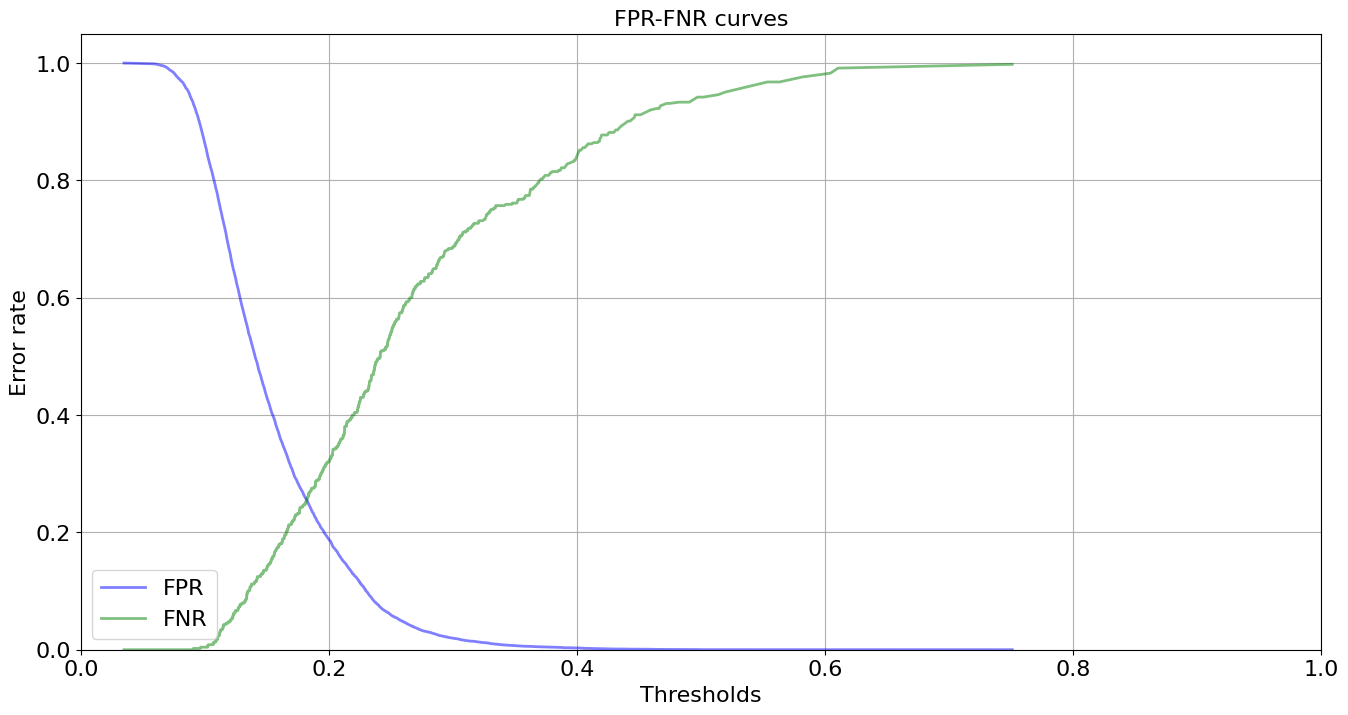

2025-10-31 23:44:42,352 | my_logger - INFO - Optimal threshold: 0.18900897666833552 | /data/aturov/scoring/src/visualization.py:77
2025-10-31 23:44:47,926 | my_logger - INFO - Optimal F1 threshold: 0.28636740747340383 | /data/aturov/scoring/src/visualization.py:86
2025-10-31 23:44:47,927 | my_logger - INFO - Optimal threshold: 0.18900897666833552, Optimal F1 threshold: 0.28636740747340383 | /tmp/ipykernel_1067461/4171357795.py:11


In [9]:
# Прогнозы и оценка метрики
train_prob3 = model3.predict_proba(X_train3)[:, 1]
y_train3 = y_train3.astype(int)  
train_metric = roc_auc_score(y_train3, train_prob3)
logger.info(f"Train ROC AUC: {train_metric}")
from src.visualization import fpr_fnr, plot_confusion_matrix


optimal_threshold, optimal_f1_threshold, path = fpr_fnr(y_train3, train_prob3, save_flg=False,
                            plt_show=True)
logger.info(f"Optimal threshold: {optimal_threshold}, Optimal F1 threshold: {optimal_f1_threshold}")

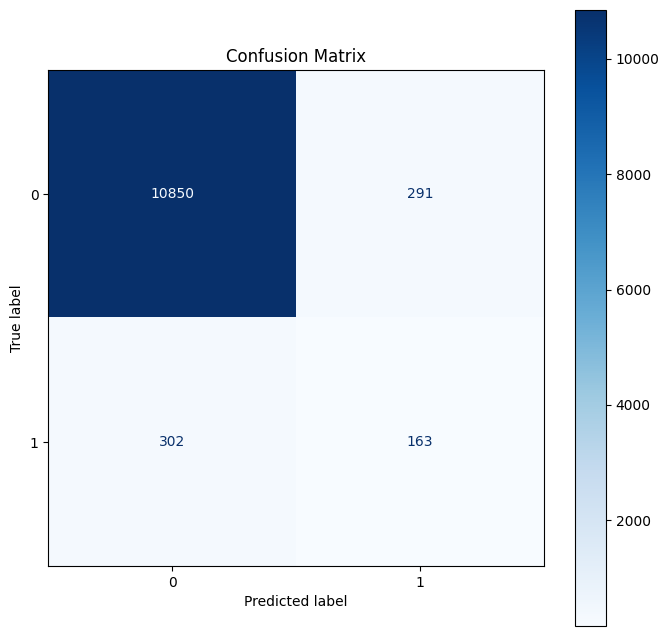

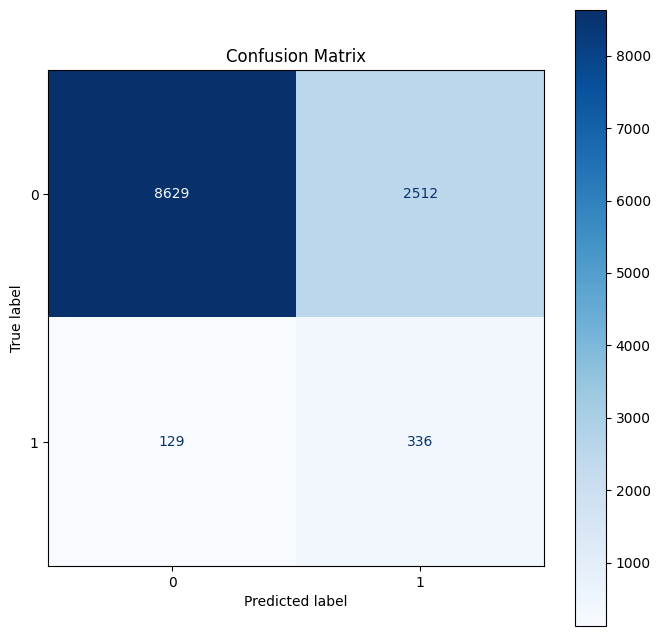

(<Figure size 800x800 with 2 Axes>, './docs/confusion_matrix.png')

In [10]:
# Построение матрицы ошибок при оптимальном пороге для F1
plot_confusion_matrix(y_train3, train_prob3, optimal_f1_threshold, 
                           save_flg=False, show_flg=True)
# Применение матрицы ошибок при оптимальном пороге пересечения FPR и FNR
plot_confusion_matrix(y_train3, train_prob3, optimal_threshold, 
                           save_flg=False, show_flg=True)


In [11]:
df_gain3, model_file_path = save_best_model(f'{NAME_MODEL_CLIENT}_final', 
                                            config.environment.model_path_final,
                                            model3, IMPORTANCE_THRESHOLD, 
                                            config.environment.data_final_path,
                                              CLASS_CLIENTS)

2025-10-31 23:44:48,232 | my_logger - INFO - Важность признаков рассчитана и нормализована. | /data/aturov/scoring/src/modeling.py:368
2025-10-31 23:44:48,233 | my_logger - INFO - Признаки с важностью выше 0 отфильтрованы. | /data/aturov/scoring/src/modeling.py:372
2025-10-31 23:44:48,238 | my_logger - INFO - Модель сохранена по пути: /data/aturov/scoring/models/final/catboost_all_final.cbm | /data/aturov/scoring/src/modeling.py:377
2025-10-31 23:44:48,241 | my_logger - INFO - Важность признаков сохранена: /data/aturov/scoring/data/final/df_gain_all.csv | /data/aturov/scoring/src/modeling.py:382


#### STEP 3.4 Visualization


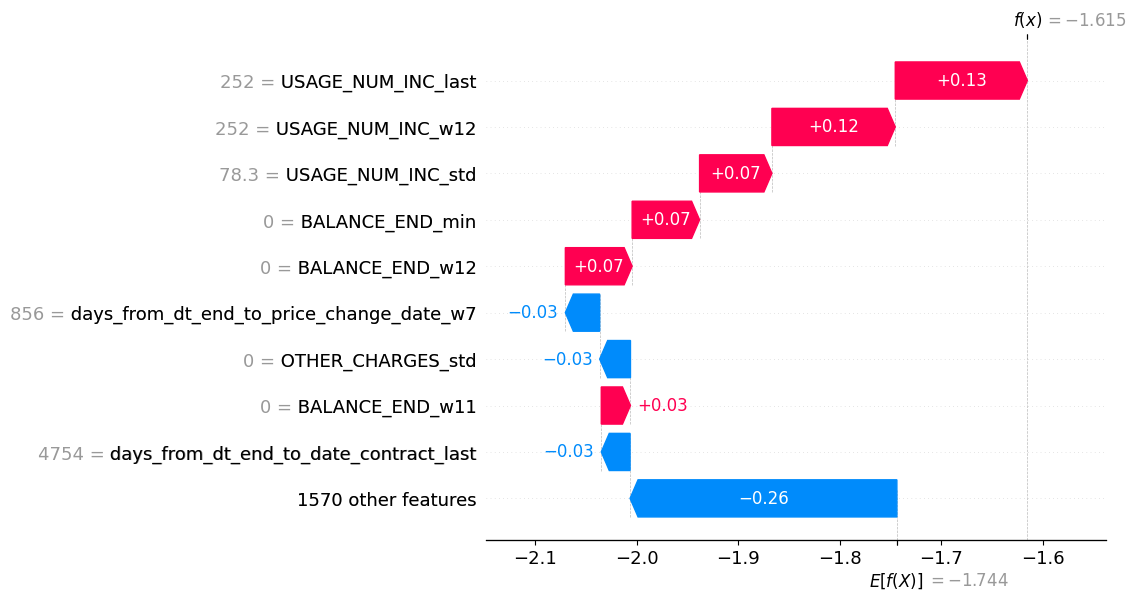

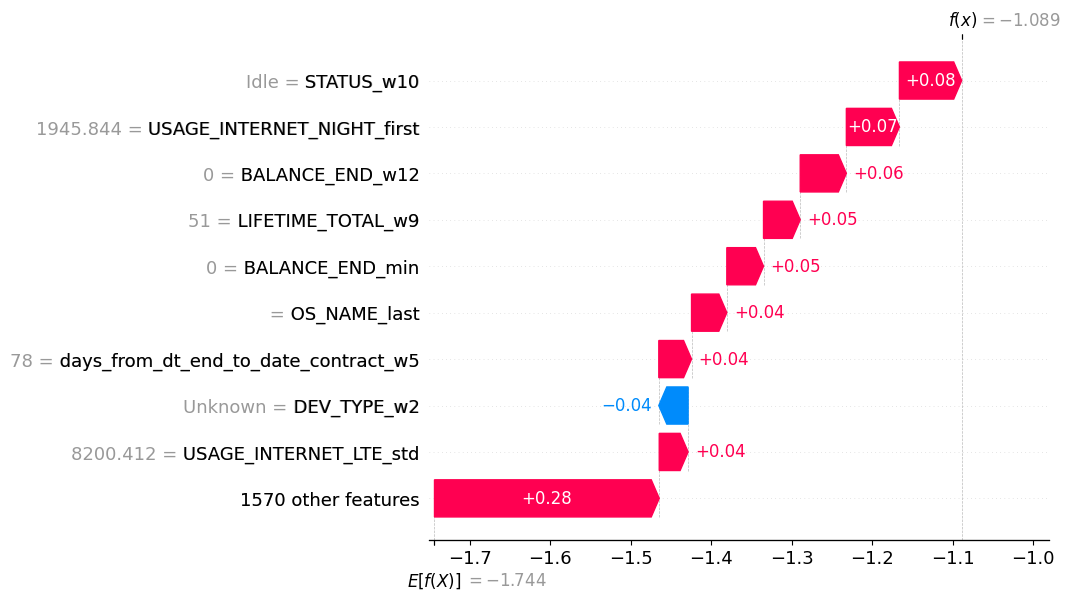

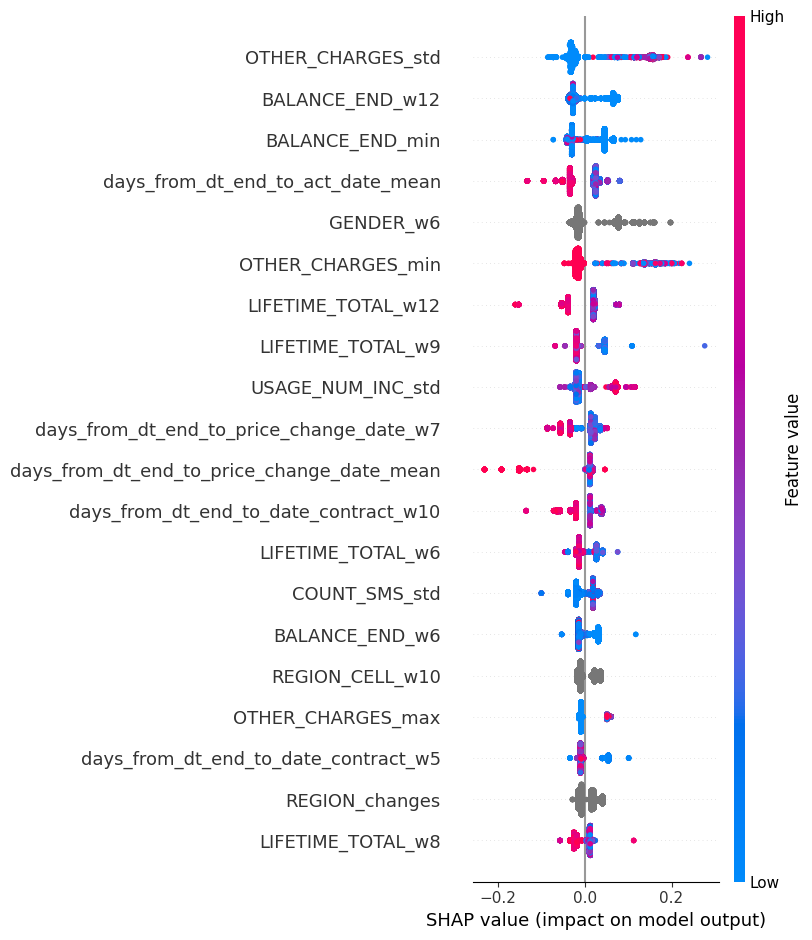

[]

In [12]:
# Вычисляем SHAP значения
from src.visualization import compute_shap_values
from src.visualization import visualize_shap_values
shap_values_class, base_value = compute_shap_values(model3, X_train3, y_train3, categorical_features3)

# Визуализируем SHAP значения
visualize_shap_values(shap_values_class, base_value, X_train3, display_plots=True)

### Stage 4 Калибровка с использованием Isotonic и Platt


In [13]:
# Шаг 3: Калибровка модели с использованием различных методов

methods = ['isotonic', 'sigmoid']  # Методы калибровки
calibrated_models = {}
probs_calibrated_list = []


In [14]:
y_train3 = y_train3.astype(int)

In [15]:
from src.calibrate_model import calibrate_model, plot_calibration_curve
for method in methods:
    calibrated_model, probs_calibrated = calibrate_model(model3, X_train3, y_train3, method)
    calibrated_models[method] = calibrated_model
    probs_calibrated_list.append((probs_calibrated, method))

# Добавление исходной модели для сравнения
probs_uncalibrated = model3.predict_proba(X_train3)[:, 1]
probs_calibrated_list.append((probs_uncalibrated, 'Uncalibrated'))

/data/aturov/scoring/.venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


/data/aturov/scoring/.venv/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(


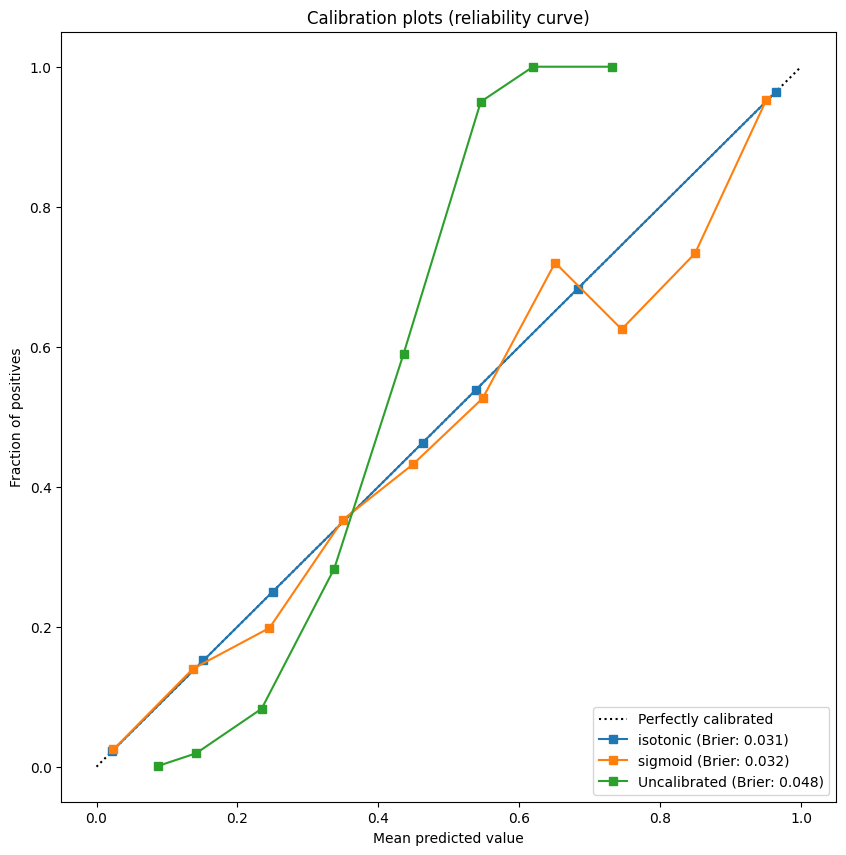

In [16]:
# Шаг 4: Построение графиков калибровки
plot_calibration_curve(y_train3, probs_calibrated_list)

In [17]:
# Сохранение калибровочных моделей
import joblib

model_file_path = f'{config.environment.model_path_final}/isotonic.pkl'
joblib.dump(calibrated_models['isotonic'], model_file_path)

model_file_path = f'{config.environment.model_path_final}/sigmoid.pkl'
joblib.dump(calibrated_models['sigmoid'], model_file_path)


['/data/aturov/scoring/models/final/sigmoid.pkl']

## OTP

In [18]:
path_gain = f'{config.environment.data_processed_path}/df_gain_{CLASS_CLIENTS}.csv'
path_train = config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
DROP_FEATURES = []
DROP_FEATURES = drop_features_func(path_gain, 
                                   DROP_FEATURES, 
                                   path_train
                                   )
len(DROP_FEATURES)

145

In [19]:
f'{config.environment.model_path_final}/{NAME_MODEL_CLIENT}_final.cbm'

'/data/aturov/scoring/models/final/catboost_all_final.cbm'

In [20]:
model_oot, best_params_oot, rounds_2stage_oot, feature_names_oot, categorical_features_oot, df_gain_oot = load_model_and_get_info(f'{config.environment.model_path_final}/{NAME_MODEL_CLIENT}_final.cbm')

2025-10-31 23:44:59,972 | my_logger - INFO - Параметры модели: {'verbose': 1, 'leaf_estimation_method': 'Newton', 'random_seed': 5345, 'border_count': 128, 'min_data_in_leaf': 12, 'random_strength': 0.640203743, 'learning_rate': 0.1, 'task_type': 'CPU', 'logging_level': 'Silent', 'iterations': 42, 'l2_leaf_reg': 4, 'od_wait': 200, 'thread_count': 60, 'depth': 4, 'bagging_temperature': 0.05, 'rsm': 0.8, 'eval_metric': 'AUC', 'leaf_estimation_iterations': 17, 'loss_function': 'Logloss', 'auto_class_weights': 'SqrtBalanced'} | /data/aturov/scoring/src/modeling.py:423
2025-10-31 23:44:59,973 | my_logger - INFO - Лучшее число итераций: None | /data/aturov/scoring/src/modeling.py:424
2025-10-31 23:44:59,974 | my_logger - INFO - Признаки: ['SUBSCRIPTION_FEE_w1', 'SUBSCRIPTION_FEE_w2', 'SUBSCRIPTION_FEE_w3', 'SUBSCRIPTION_FEE_w4', 'SUBSCRIPTION_FEE_w5', 'SUBSCRIPTION_FEE_w6', 'SUBSCRIPTION_FEE_w7', 'SUBSCRIPTION_FEE_w8', 'SUBSCRIPTION_FEE_w9', 'SUBSCRIPTION_FEE_w10', 'SUBSCRIPTION_FEE_w11', 'S

In [21]:
best_params_oot

{'leaf_estimation_method': 'Newton',
 'random_seed': 5345,
 'border_count': 128,
 'min_data_in_leaf': 12,
 'random_strength': 0.640203743,
 'learning_rate': 0.1,
 'task_type': 'CPU',
 'logging_level': 'Silent',
 'l2_leaf_reg': 4,
 'od_wait': 200,
 'thread_count': 60,
 'depth': 4,
 'bagging_temperature': 0.05,
 'rsm': 0.8,
 'eval_metric': 'AUC',
 'leaf_estimation_iterations': 17,
 'loss_function': 'Logloss',
 'auto_class_weights': 'SqrtBalanced'}

In [22]:
# Обработка данных и разделение на обучающую и тестовую выборки
path_train = config.environment.data_final_path / f'{NAME_DATASET}_train_{DATE_FEATURES}.parquet'
path_oot = config.environment.data_final_path / f'{NAME_DATASET}_val_{DATE_FEATURES}.parquet'

X_train4, y_train4, _, _ = load_and_preprocess_data(path_train, DROP_FEATURES, 
                                                    NORM, THRESHOLD_UNIQUE, TARGET_COL,
                                                    del_col_flag=False, 
                                                    categorical_features=categorical_features_oot
                                                    )
logger.info(f'Размер датафрейма{X_train4.shape}')
X_oot, y_oot, _, _ = load_and_preprocess_data(path_oot, DROP_FEATURES, 
                                                    NORM, THRESHOLD_UNIQUE, TARGET_COL,
                                                    del_col_flag=False, 
                                                    categorical_features=categorical_features_oot
                                                    )
logger.info(f'Размер датафрейма помле фильтрации признаков {X_oot.shape}')

2025-10-31 23:45:01,178 | my_logger - INFO - Размер датафрейма(11606, 1579) | /tmp/ipykernel_1067461/2181133877.py:10
2025-10-31 23:45:01,573 | my_logger - INFO - Размер датафрейма помле фильтрации признаков (1858, 1579) | /tmp/ipykernel_1067461/2181133877.py:16


In [23]:
X_oot.shape, y_oot.shape, X_train4.shape, y_train4.shape

((1858, 1579), (1858,), (11606, 1579), (11606,))

In [24]:
# Прогнозы и оценка метрики
train_prob4 = model_oot.predict_proba(X_train4)[:, 1]
y_train4 = y_train4.astype(int)  
train_metric = roc_auc_score(y_train4, train_prob4)
train_metric

0.826270011089524

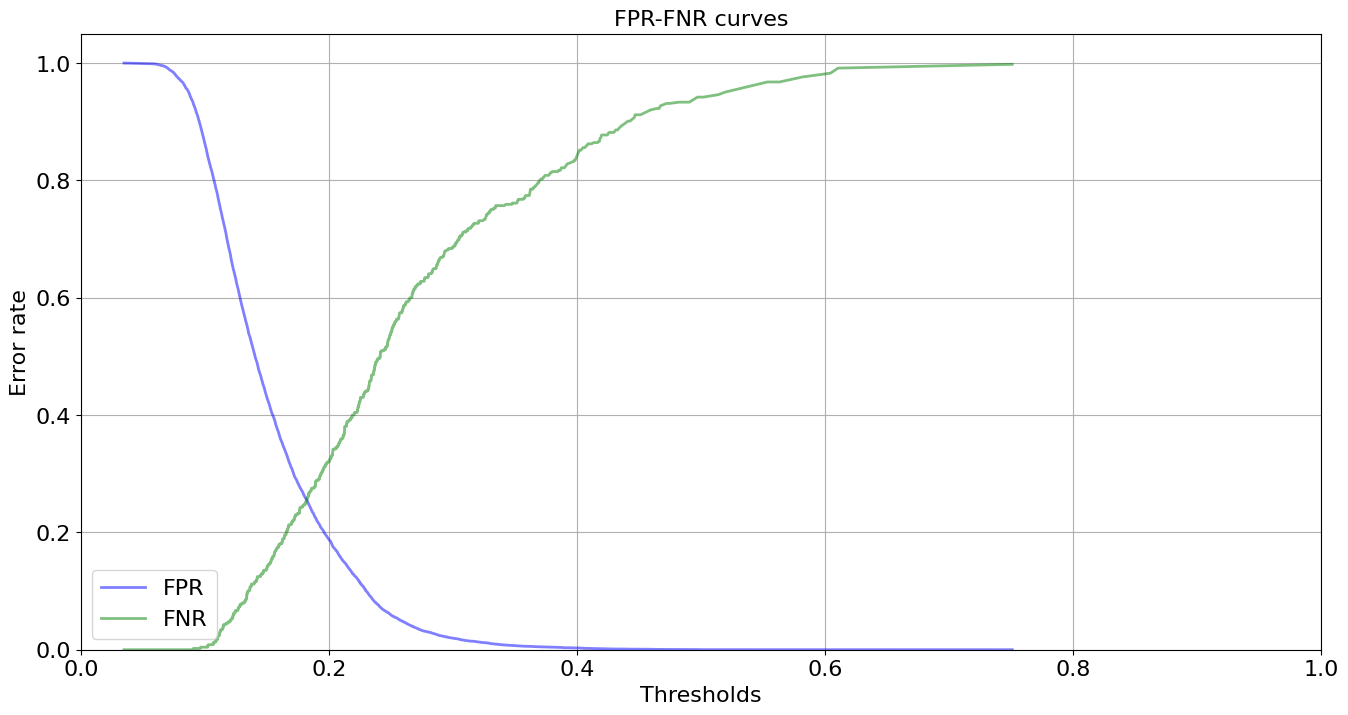

2025-10-31 23:45:02,824 | my_logger - INFO - Optimal threshold: 0.18900897666833552 | /data/aturov/scoring/src/visualization.py:77
2025-10-31 23:45:08,503 | my_logger - INFO - Optimal F1 threshold: 0.28636740747340383 | /data/aturov/scoring/src/visualization.py:86


Optimal Threshold: 0.18900897666833552


In [25]:
# Шаг 3: Определение оптимального порога на основе тренировочных данных


from src.visualization import fpr_fnr, plot_confusion_matrix
optimal_threshold, optimal_f1_threshold, path = fpr_fnr(y_train4, train_prob4, save_flg=False,
                            plt_show=True)
print(f'Optimal Threshold: {optimal_threshold}')


In [26]:
# Шаг 5: Предсказание вероятностей для тренировочных и тестовых данных
y_train_proba = model_oot.predict_proba(X_train4)[:, 1]
y_oot_proba = model_oot.predict_proba(X_oot)[:, 1]
# Применение порога для получения предсказанных классов
y_train_pred = (y_train_proba >= optimal_threshold).astype(int)
y_oot_pred = (y_oot_proba >= optimal_threshold).astype(int)

In [27]:
# Сохранение истинных меток и предсказаний в словарь
y_train = y_train.astype(int)
y_oot = y_oot.astype(int)
vectors = dict(
    MAIN=[y_train, y_train_proba],
    OOT=[y_oot, y_oot_proba]
)

In [28]:
y_train.shape, y_train_proba.shape, y_oot.shape, y_oot_proba.shape

((11606,), (11606,), (1858,), (1858,))

In [29]:
   # OOT метки и вероятности
from src.visualization import get_save_metrics
y_oot = y_oot.astype(int)
y_oot_proba = model_oot.predict_proba(X_oot)[:, 1]
results_metrics = get_save_metrics(
    X_train4,
    y_train4,          # numeric labels
    y_train_proba,          # train probabilities (same sample as df)
    y_oot,                  # oot labels (int)
    y_oot_proba,            # oot probabilities
    BETA,
    best_params_oot,
    optimal_threshold,
    save_to_mlflow=False
)
results_metrics

2025-10-31 23:45:09,965 | my_logger - INFO - Metrics computed successfully. | /data/aturov/scoring/src/visualization.py:586
2025-10-31 23:45:09,965 | my_logger - INFO - MLflow run completed. | /data/aturov/scoring/src/visualization.py:610


,Number of columns,ROC AUC TRAIN,Precision TRAIN,Recall TRAIN,F1-Score TRAIN,Accuracy TRAIN,ROC AUC OOT,Precision OOT,Recall OOT,F1-Score OOT,Accuracy OOT,objective
0,1579,0.82627,0.117978,0.722581,0.202837,0.772445,0.740831,0.830435,0.475914,0.605069,0.597417,0.686
